In [87]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time

In [88]:
import astropy.units as u
import astropy.cosmology.units as cu
import astropy.constants as const

In [89]:
import raytrace

In [90]:
group_id = str(12925051)

In [91]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    print(f[group_id].keys())
    cm = np.array(f[group_id]['GroupCM'], dtype=np.float64)
    r500 = np.float64(f[group_id]['Group_R_Crit500'])

<KeysViewHDF5 ['DM', 'DMSphere', 'Direction', 'GroupCM', 'GroupMassType', 'GroupSFR', 'Group_R_Crit500', 'Impact', 'RayID']>


In [92]:
with h5py.File(f'tng_cache/cutout_{group_id}.hdf5', 'r') as f:
    m_g = np.array(f['PartType0/Masses'], dtype=np.float64) * (1e10 * u.solMass).to(u.kg) / cu.littleh
    rho_g = np.array(f['PartType0/Density'], dtype=np.float64) * (1e10 * u.solMass).to(u.kg) / cu.littleh / ( u.kpc / cu.littleh)**3
    V = m_g/rho_g
    r = ((0.75/np.pi)*V)**(1/3)
    eta_e = np.array(f['PartType0/ElectronAbundance'])
    X_H = np.array(f['PartType0/GFM_Metals'][:,0])
    pos = np.array(f['PartType0/Coordinates'][:]) - cm
    n_e = rho_g * eta_e * X_H / const.m_p

In [93]:
pos.size

3000243

In [94]:
samples = 100

In [95]:
indices = np.arange(samples, dtype=np.int64)
impact = np.zeros((samples, 3), dtype=np.float64)
direction = np.zeros((samples, 3), dtype=np.float64)
dispersion = np.zeros(samples, dtype=np.float64)
dispersion_sphere = np.zeros(samples, dtype=np.float64)

In [105]:
for i in indices:
    t = time.time()
    b = r500 * np.random.rand(3) # impact parameter
    n = np.random.rand(3) # direction
    n /= np.sqrt(raytrace.norm2(n))
    intersects, lengths = raytrace.voronoi_intersect(pos, 5*r.value, b, n, log=False)
    dm = np.sum(lengths * n_e.value[intersects])

    impact[i] = b
    direction[i] = n
    dispersion[i] = dm
    print(i, time.time() - t)


0 0.8385107517242432
1 0.8189988136291504
2 0.4873383045196533
3 0.4115004539489746
4 0.6405117511749268
5 0.41675543785095215
6 0.4558990001678467
7 0.6972358226776123
8 0.697014331817627
9 0.492661714553833
10 0.4763956069946289
11 0.7983105182647705
12 0.6609289646148682
13 1.1684918403625488
14 0.9006984233856201
15 0.7863032817840576
16 0.7510025501251221
17 0.47999000549316406
18 0.6086287498474121
19 0.5351901054382324
20 0.5818381309509277
21 0.6219325065612793
22 0.7005743980407715
23 0.6873793601989746
24 0.5128333568572998
25 0.4633469581604004
26 0.7198708057403564
27 0.6357300281524658
28 0.5652823448181152
29 0.7088108062744141
30 0.7586159706115723
31 0.7278280258178711
32 1.0225121974945068
33 0.741891622543335
34 0.5747148990631104
35 0.7476723194122314
36 0.6134870052337646
37 0.6444649696350098
38 0.7493021488189697
39 0.4846479892730713
40 0.6614990234375
41 0.535027265548706
42 0.9461393356323242
43 0.6597015857696533
44 0.6230051517486572
45 0.7086663246154785
46 

In [106]:
dispersion_sphere = np.zeros(samples, dtype=np.float64)
for i in indices:
    t = time.time()
    b = impact[i]
    n = direction[i]
    intersects, lengths = raytrace.sphere_intersect(pos, r.value, b, n, log=False)
    dm = np.sum(lengths * n_e.value[intersects])
    dispersion_sphere[i] = dm
    times.append(time.time() - t)
print('time:',np.mean(times))

time: 0.034005317687988285


In [107]:
with h5py.File("outputs/dm_proto.hdf5", "a") as f:
    print(f.keys())
    f[group_id]["RayID"][:] = indices
    f[group_id]["Impact"][:] = impact
    f[group_id]["Direction"][:] = direction
    f[group_id]["DM"][:] = dispersion
    f[group_id]["DMSphere"][:] = dispersion_sphere

<KeysViewHDF5 ['12925051']>


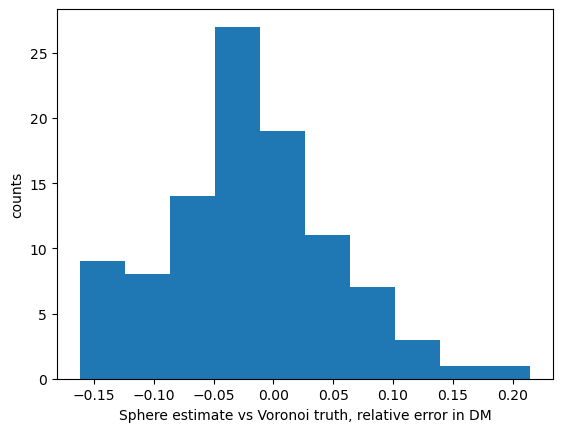

In [108]:
with h5py.File("outputs/dm_proto.hdf5", "r") as f:
    plt.hist(np.array(f[group_id]['DMSphere'])/np.array(f[group_id]['DM']) - 1)
    plt.xlabel('Sphere estimate vs Voronoi truth, relative error in DM')
    plt.ylabel('counts')

In [104]:
import importlib
importlib.reload(raytrace)

<module 'raytrace' from '/home/xingyzt/Documents/halo/raytrace.py'>